# Data preparation, exploration and sorting

# Downloading packages and loading libraries
This section imports all the necessary libraries and modules required for the script to run. It includes libraries for data manipulation, visualization, machine learning models, image preprocessing, and model evaluation.

In [ ]:
! pip install tensorflow_addons
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary libraries
import os
import random
from random import randint
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colormaps
import visualkeras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, ResNet50, Xception, InceptionV3, DenseNet169, EfficientNetB0, MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC, roc_curve, auc, balanced_accuracy_score as BAS, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from distutils.dir_util import copy_tree, remove_tree

# Installing the Kaggle API client and setting up the Kaggle configuration file

After running these commands, it is possible to use the Kaggle API client to interact with Kaggle datasets and competitions. `kaggle.json` file is created via Kaggle and uploaded manually to Colab.

In [ ]:
# Install the Kaggle API client package using pip
! pip install kaggle
# Create a directory named `.kaggle` in the user's home directory (`~`), which is where the Kaggle configuration file will be stored
! mkdir ~/.kaggle
# Copy the Kaggle API credentials file (`kaggle.json`) to the newly created `.kaggle` directory
! cp kaggle.json ~/.kaggle/
# Change the permissions of the `kaggle.json` file to make it readable and writable only by the owner (the user), ensuring that the API credentials are secure
! chmod 600 ~/.kaggle/kaggle.json


#Setting the random seed to the same value
This ensures reproducibility of results when using random number generation functions, which is especially important in machine learning tasks where randomness is involved, such as weight initialization, data shuffling, or dropout. By setting the random seed, random numbers generated during different runs of the script remain the same, providing consistent and comparable results.

In [ ]:
tf.random.set_seed(5638)
random.seed(5638)

#Downloading the dataset named "alzheimers-dataset-4-class-of-images" from Kaggle

This dataset is related to Alzheimer's disease and contains images categorized into four classes.

In [ ]:
! kaggle datasets download -d zofiaknapiska/alzheimer-augumented-dataset-v3

Dataset URL: https://www.kaggle.com/datasets/zofiaknapiska/alzheimer-augumented-dataset-v3
License(s): unknown
 99% 61.0M/61.9M [00:05<00:00, 16.7MB/s]
100% 61.9M/61.9M [00:05<00:00, 12.8MB/s]


#Unzipping and exploring the dataset

In [ ]:
! unzip '/content/alzheimer-augumented-dataset-v3.zip'

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: archive/train/CN/bfe809d2-5b35-4862-a23f-a8975a4b9e99.jpg  
  inflating: archive/train/CN/bfedda9c-1167-4426-b908-c776dd3b5b56.jpg  
  inflating: archive/train/CN/c0020f7d-2d1e-495d-9851-8d241c5c36b3.jpg  
  inflating: archive/train/CN/c023e163-7f63-4444-9191-ba8d86042b00.jpg  
  inflating: archive/train/CN/c0257c6e-ff02-43de-b7e9-2679792fea31.jpg  
  inflating: archive/train/CN/c04dd044-e3ad-4590-b12a-b55570769d00.jpg  
  inflating: archive/train/CN/c06f989d-1069-4d77-baa6-87bc8de5faca.jpg  
  inflating: archive/train/CN/c0881aa3-f06c-44c8-9c44-59149bdc027e.jpg  
  inflating: archive/train/CN/c096d86d-707e-4ec5-bcb1-e0d0ae958d86.jpg  
  inflating: archive/train/CN/c0d5a888-d568-42d6-bb55-713c1f76dfe8.jpg  
  inflating: archive/train/CN/c0d8cc95-2d29-4ce4-b5f3-fbcdd6faddb8.jpg  
  inflating: archive/train/CN/c0ec3ace-ee49-45e9-8721-0b782e7fe9eb.jpg  
  inflating: archive/train/CN/c10383e0-e638-451f-b114-fef52

#Preparing the data for training and testing

#Defining parameters for training a neural network model

Setting parameters and configurations for image processing and neural network training. These parameters help in standardizing the input images and controlling the training process, ensuring consistency and efficiency.

In [ ]:
# Define the number of epochs, which is the number of times the entire dataset will be passed forward and backward through the neural network during training
EPOCHS = 50

# Set the batch size, which determines the number of samples that will be propagated through the network at a time
BATCH_SIZE = 32

# Define the size to which the images will be resized in pixels
IMG_SIZE = 192

#Store the image size as a list with two elements, both set to 128
IMAGE_SIZE = [192, 192, 3]

# Define the dimensions to which the images will be resized as a tuple
DIM = (IMG_SIZE, IMG_SIZE)

# Visualizing the distribution of labels in the training set
The labels correspond to the different stages of Alzheimer's in the training dataset. They provide insight into the balance or imbalance of classes, which is crucial for training a machine learning model effectively.

In [ ]:
# Path to the directory containing training images of an Alzheimer's dataset
# train_dir = Path('/content/Alzheimer_s Dataset/train/')
train_dir = Path('/content/archive/train')

# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
train_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
train_df = train_df.sample(frac=1).reset_index(drop = True)

In [ ]:
# Split training data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['Label'], random_state=5638)

# Visualizing the distribution of labels in the testing set
The labels correspond to the different stages of Alzheimer's in the training dataset. They provide insight into the balance or imbalance of classes, which is crucial for training a machine learning model effectively.

In [ ]:
# Path to the directory containing testing images of an Alzheimer's dataset
# test_dir = Path('/content/Alzheimer_s Dataset/test/')
test_dir = Path('/content/archive/test')

# Get filepaths and labels
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
test_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
test_df = test_df.sample(frac=1).reset_index(drop = True)

#Utilizing `ImageDataGenerator` to prepare image data for training and testing
Setting up data pipelines for training and testing deep learning models using Keras. Automating data preprocessing tasks such as scaling and batching, making it easier to work with large datasets efficiently.

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(192,192),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=True
)

val_images = test_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(192, 192),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=5638,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(192, 192),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())
num_classes = len(CLASSES)

Found 9600 validated image filenames belonging to 3 classes.
Found 2400 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


#Calculating and visualizing the distribution of classes within both the training and testing datasets

In [ ]:
# Retrieve class indices mapping for both training and testing datasets
train_class_indices = train_images.class_indices
test_class_indices = test_images.class_indices

# Get the total number of classes present in the dataset
num_classes = len(train_class_indices)

# Initialize dictionaries to store counts of each class in the training and testing datasets
train_class_counts = {class_name: 0 for class_name in train_class_indices}
test_class_counts = {class_name: 0 for class_name in test_class_indices}

# Update counts for each class in the training set
for label in train_images.labels:
    class_name = CLASSES[label]
    train_class_counts[class_name] += 1

# Update counts for each class in the testing set
for label in test_images.labels:
    class_name = CLASSES[label]
    test_class_counts[class_name] += 1

# Combine counts for both training and testing datasets
combined_class_counts = {}
for class_name in train_class_counts.keys():
    combined_class_counts[class_name] = [train_class_counts[class_name], test_class_counts[class_name]]

#Working with the CNN

#Defining a convolutional neural network (CNN) model

1. **Input Layer**: Accepts input images of size (128, 128) with 3 channels (RGB).
2. **Convolutional Layers**: A series of convolutional layers with increasing filter sizes (16, 32, 64, 128, 256), each followed by ReLU activation and same padding.
3. **Pooling Layers**: Max pooling layers after every two convolutional layers to downsample the spatial dimensions.
4. **Batch Normalization**: Batch normalization layers after some convolutional layers to stabilize and accelerate the training process.
5. **Flatten Layer**: Flattens the output from the convolutional layers into a 1D array.
6. **Dropout Layers**: Dropout layers with dropout rates of 0.2, 0.7, 0.5, and 0.3, respectively, to prevent overfitting by randomly dropping neurons during training.
7. **Dense Layers**: Fully connected dense layers with 512, 128, and 64 units, followed by ReLU activation, batch normalization, and dropout regularization.
8. **Output Layer**: Dense layer with 4 units (assuming it's a classification task with 4 classes), activated by softmax to output class probabilities.

In [ ]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Label']),
    y=train_df['Label']
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
def create_model():
    base_model = InceptionV3(weights='imagenet',
                             include_top=False,
                             input_shape=(192, 192, 3))

    # Calculating the total number of layers in the base model
    total_layers = len(base_model.layers)
    # Calculating the number of layers to fine-tune
    # (half of the total layers)
    fine_tune_layers = total_layers // 2
    # Unfreezing the top layers for fine-tuning
    for layer in base_model.layers[:-fine_tune_layers]:
        layer.trainable = False

    # Adding custom top layers for classification
    x = base_model.output

    # Adds additional feature extraction capabilities
    # allowing the model to capture more task-specific patterns
    x = Conv2D(128, (3, 3), activation='relu')(x)
    # Normalizes the activations of the previous layer
    # helping stabilize and speed up the training process
    x = BatchNormalization()(x)
    # Reduces the spatial dimensions of the feature maps
    # helping focus on the most important features
    x = MaxPooling2D((2, 2))(x)
    # Prevents overfitting by randomly setting a fraction
    # of weights to 0 during training
    x = Dropout(0.3)(x)

    # Converts the 2D feature maps into a 1D feature vector
    x = Flatten()(x)
    # Introduces a fully connected layer allowing the model
    # to learn complex combinations of the features extracted
    # by the convolutional layers
    x = Dense(256, activation='relu')(x)
    # Further regularizes the model by preventing overfitting
    x = Dropout(0.3)(x)

    # Output layer using the softmax activation function
    # to yield probabilities for each one of three classes
    # enabling multi-class classification.
    predictions = Dense(3, activation='softmax')(x)

    # Combining the base model with custom top layers
    model = tensorflow.keras.Model(inputs=base_model.input,
                                   outputs=predictions)
    return model

model = create_model()

87910968/87910968 [==============================] - 5s 0us/step


#Setting up the optimizer, defining evaluation metrics, and compiling the model for training

1. **Optimizer Definition** - Defines the Adam optimizer with a learning rate of 0.001 and assigns it to the variable `OPT`.

2. **Metrics Configuration** - Defines a list of metrics to evaluate the model's performance during training and validation.

3. **Model Compilation**



In [ ]:
# Define the Adam optimizer with a learning rate of 0.001 and assign it to the variable OPT
OPT = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define a list of evaluation metrics to be used during model training and validation
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),  # Computes accuracy for multi-class classification
    tf.keras.metrics.AUC(name='auc'),                  # Computes area under the ROC curve for binary classification
    tfa.metrics.F1Score(num_classes=3)                 # Computes F1 score for multi-class classification with 4 classes
]

# Compile the model
model.compile(optimizer=OPT, loss='categorical_crossentropy', metrics=METRICS)

from contextlib import redirect_stdout
with open('modelsummary_model.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary(show_trainable = True)

# Display model summary
model.summary(show_trainable = True)

Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 192, 192, 3)]        0         []                            N          
                                                                                                             
 conv2d_1 (Conv2D)           (None, 95, 95, 32)           864       ['input_2[0][0]']             N          
                                                                                                             
 batch_normalization_1 (Bat  (None, 95, 95, 32)           96        ['conv2d_1[0][0]']            N          
 chNormalization)                                                                                            
                                                                                                       

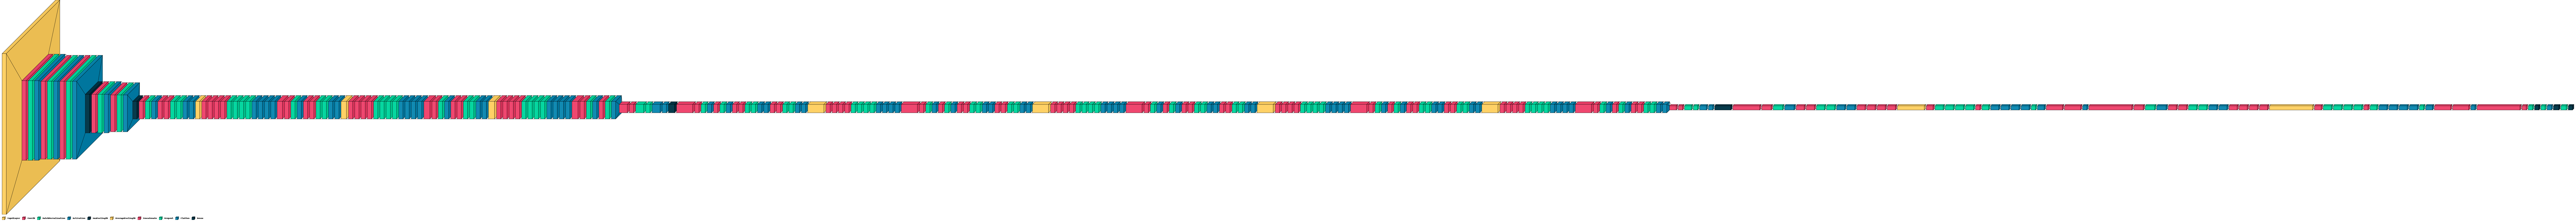

In [ ]:
# font = ImageFont.truetype('arial.ttf', 12)
visualkeras.layered_view(model, to_file='model_viskeras.png', legend=True)

In [ ]:
#Calling plot_model method and displaying a model structure summary
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=100, show_layer_activations=True, show_trainable=True)
# plot_model(model_vgg16, to_file='model_vgg16_structure.png', show_shapes=True, expand_nested=True, show_layer_names=True, dpi=100)

#Defining callbacks essential for monitoring the training process, preventing overfitting, and saving the best model weights

1. **Early Stopping Configuration** - configures early stopping, which halts training when the monitored validation loss (`val_loss`) stops decreasing.

2. **Model Checkpointing Configuration** - configures model checkpointing, which saves the model weights with the lowest validation loss (`val_loss`).

3. **Callback List** - creates a list of callbacks to be used during model training. It includes both early stopping and model checkpointing callbacks, ensuring that the training process is monitored and the best model weights are saved.



In [ ]:
# Configure early stopping, halting training when the validation loss stops decreasing
earlystopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss during training
    mode='min',            # Stop training when the monitored quantity (val_loss) stops decreasing
    patience=7,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Print messages about early stopping progress during training
    restore_best_weights = True
)

# Define the filepath where the best model weights will be saved during training
filepath = './model_best_weights.keras'

# Configure model checkpointing to save the best model weights based on validation loss
checkpoint = ModelCheckpoint(
    filepath,              # Filepath to save the best model weights
    monitor='val_loss',    # Monitor the validation loss during training
    mode='min',            # Save the weights when the monitored quantity (val_loss) achieves its minimum value
    save_best_only=True,   # Save only the best model weights (with the lowest validation loss)
    verbose=1              # Print messages about model checkpointing progress during training
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6)

# Create a list of callbacks to be used during model training, including early stopping and model checkpointing
callback_list = [earlystopping, checkpoint, reduce_lr]

#Training and Validating a Custom Model

Fitting the training data to a custom machine learning model (`custom_model_v1`) and validating its performance using separate validation data (`test_images`). The code employs callbacks specified in `callback_list` to monitor and control the training process. The `epochs` parameter determines the number of times the entire training dataset is passed forward and backward through the model.


In [ ]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    callbacks=callback_list,
    epochs=EPOCHS,
    class_weight=class_weights  # Add class weights to handle class imbalance
)

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.8252 - acc: 0.6290 - auc: 0.8246 - f1_score: 0.6271
Epoch 1: val_loss improved from inf to 0.49937, saving model to ./model_best_weights.keras
300/300 [==============================] - 138s 383ms/step - loss: 0.8252 - acc: 0.6290 - auc: 0.8246 - f1_score: 0.6271 - val_loss: 0.4994 - val_acc: 0.7733 - val_auc: 0.9348 - val_f1_score: 0.7600 - lr: 1.0000e-04
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.4856 - acc: 0.7781 - auc: 0.9308 - f1_score: 0.7779
Epoch 2: val_loss improved from 0.49937 to 0.37770, saving model to ./model_best_weights.keras
300/300 [==============================] - 144s 481ms/step - loss: 0.4856 - acc: 0.7781 - auc: 0.9308 - f1_score: 0.7779 - val_loss: 0.3777 - val_acc: 0.8163 - val_auc: 0.9567 - val_f1_score: 0.8154 - lr: 1.0000e-04
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.4124 - acc: 0.8053 - auc: 0.9485 - f1_score: 0.8051
Epoch 3: v

#Monitoring Model Performance with Accuracy and Loss Plots

Generating two plots to monitor the performance of a custom machine learning model during training and validation.

The first plot displays the model's accuracy over epochs, with separate lines for training and validation accuracy. This plot helps visualize how well the model is learning from the training data and how well it generalizes to unseen data.

The second plot shows the model's loss over epochs, again with separate lines for training and validation loss. Loss indicates how well the model's predictions match the actual targets; lower loss values indicate better performance.

By observing these plots, we can assess whether the model is overfitting or underfitting.

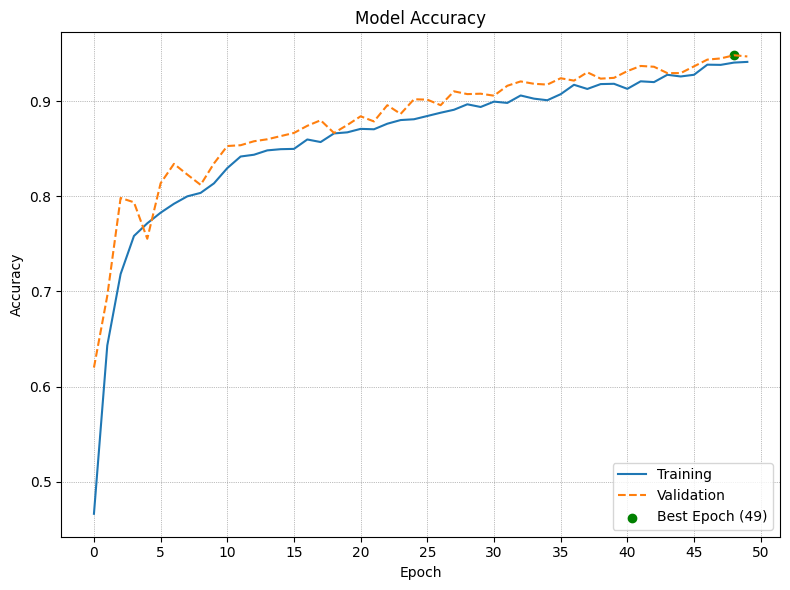

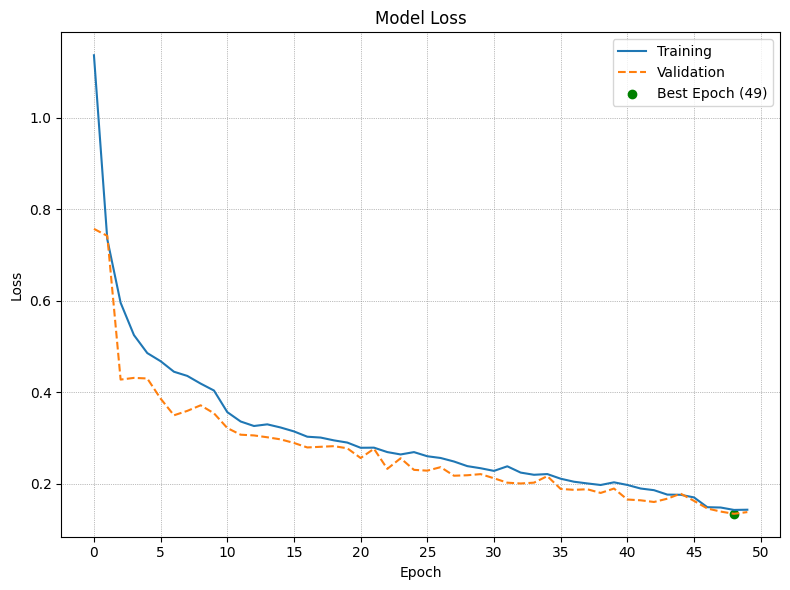

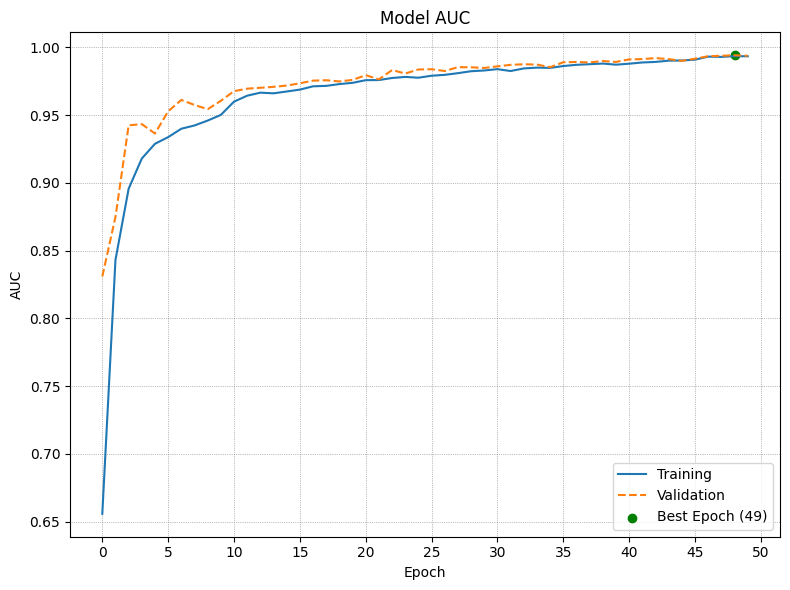

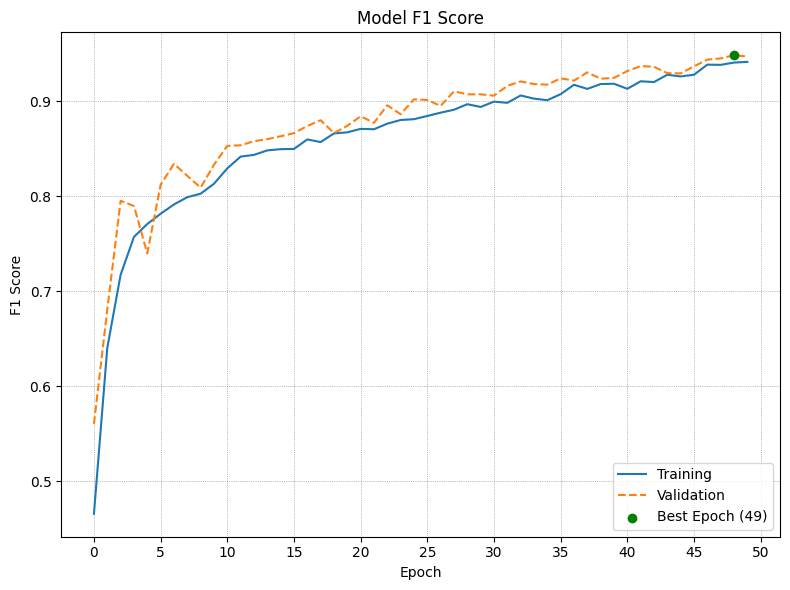

In [ ]:
# Create a figure and axes for the accuracy plot
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add a delicate grid in the background
plt.plot(history.history['acc'], linestyle='-', label='Training')  # Plot training accuracy without markers
plt.plot(history.history['val_acc'], linestyle='--', label='Validation')  # Plot validation accuracy without markers
plt.title('Model Accuracy')  # Set title for the plot
plt.ylabel('Accuracy')  # Label y-axis
plt.xlabel('Epoch')  # Label x-axis
plt.xticks(range(0, len(history.history['acc'])+1, max(1, len(history.history['acc'])//10)))  # Dynamic x-axis based on the number of epochs

# Find and mark the best epoch for validation accuracy
best_epoch_val_acc = history.history['val_acc'].index(max(history.history['val_acc']))
plt.scatter(best_epoch_val_acc, max(history.history['val_acc']), color='green', label=f'Best Epoch ({best_epoch_val_acc + 1})')

plt.legend(loc='lower right')  # Add legend to indicate which line represents train and validation
plt.tight_layout()  # Adjust layout to prevent overlapping of elements
plt.savefig('acc.png')
plt.show()  # Display the plot

# Create a figure and axes for the loss plot
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add a delicate grid in the background
plt.plot(history.history['loss'], linestyle='-', label='Training')  # Plot training loss without markers
plt.plot(history.history['val_loss'], linestyle='--', label='Validation')  # Plot validation loss without markers
plt.title('Model Loss')  # Set title for the plot
plt.ylabel('Loss')  # Label y-axis
plt.xlabel('Epoch')  # Label x-axis
plt.xticks(range(0, len(history.history['loss'])+1, max(1, len(history.history['loss'])//10)))  # Dynamic x-axis based on the number of epochs

# Find and mark the best epoch for validation loss
best_epoch_val_loss = history.history['val_loss'].index(min(history.history['val_loss']))
plt.scatter(best_epoch_val_loss, min(history.history['val_loss']), color='green', label=f'Best Epoch ({best_epoch_val_loss + 1})')

plt.legend(loc='upper right')  # Add legend to indicate which line represents train and validation
plt.tight_layout()  # Adjust layout to prevent overlapping of elements
plt.savefig('loss.png')
plt.show()  # Display the plot

# Create a figure and axes for the AUC plot
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add a delicate grid in the background
plt.plot(history.history['auc'], linestyle='-', label='Training')  # Plot training AUC without markers
plt.plot(history.history['val_auc'], linestyle='--', label='Validation')  # Plot validation AUC without markers
plt.title('Model AUC')  # Set title for the plot
plt.ylabel('AUC')  # Label y-axis
plt.xlabel('Epoch')  # Label x-axis
plt.xticks(range(0, len(history.history['auc'])+1, max(1, len(history.history['auc'])//10)))  # Dynamic x-axis based on the number of epochs

# Find and mark the best epoch for validation AUC
best_epoch_val_auc = history.history['val_auc'].index(max(history.history['val_auc']))
plt.scatter(best_epoch_val_auc, max(history.history['val_auc']), color='green', label=f'Best Epoch ({best_epoch_val_auc + 1})')

plt.legend(loc='lower right')  # Add legend to indicate which line represents train and validation
plt.tight_layout()  # Adjust layout to prevent overlapping of elements
plt.savefig('auc.png')
plt.show()  # Display the plot

# Assuming `custom_model_history` is your history object from model training
# Get F1 scores from the history
f1_scores_train = history.history['f1_score']
f1_scores_val = history.history['val_f1_score']

# Create a figure and axes for the F1 score plot
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add a delicate grid in the background

# Plot training F1 score with a solid line
f1_scores_train_avg = np.mean(f1_scores_train, axis=1)
plt.plot(f1_scores_train_avg, linestyle='-', label='Training')

# Plot validation F1 score with a dashed line
f1_scores_val_avg = np.mean(f1_scores_val, axis=1)
plt.plot(f1_scores_val_avg, linestyle='--', label='Validation')

# Find and mark the best epoch for validation F1 score
best_epoch_val_f1 = np.argmax(f1_scores_val_avg)
plt.scatter(best_epoch_val_f1, f1_scores_val_avg[best_epoch_val_f1], color='green', zorder=5, label=f'Best Epoch ({best_epoch_val_f1 + 1})')

plt.title('Model F1 Score')  # Set title for the plot
plt.ylabel('F1 Score')  # Label y-axis
plt.xlabel('Epoch')  # Label x-axis
plt.xticks(range(0, len(f1_scores_train_avg) + 1, max(1, len(f1_scores_train_avg) // 10)))  # Dynamic x-axis based on the number of epochs

plt.legend(loc='lower right')  # Add legend to indicate which line represents train and validation
plt.tight_layout()  # Adjust layout to prevent overlapping of elements
plt.savefig('f1_score.png')
plt.show()  # Display the plot

#Evaluating Model Performance and Generating Classification Report

The performance of a custom machine learning model is evaluated using the test dataset.

First, the `evaluate` method is called on the model with the test images, providing evaluation scores. The accuracy of the model on the test data is then printed.

Next, the model predicts labels for the test images using the `predict` method. The predicted labels are then processed using a `roundoff` function, which rounds off each predicted label array by setting non-maximum values to 0 and the maximum value to 1.

After rounding off the predicted labels, the index of the maximum value along axis 1 is extracted to get the final predicted labels.

Finally, a classification report is generated using the `classification_report` function from scikit-learn, comparing the predicted labels against the true labels in the test dataset. The classification report provides metrics such as precision, recall, and F1-score for each class, aiding in the evaluation of the model's performance across different classes.

In [ ]:
from google.colab import files
files.download('/content/model_best_weights.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
# # Provide the path to the saved model file (.h5 format)
model_path = '/content/model_best_weights.keras'
# # Load the model
loaded_model = load_model(model_path)

test_scores = loaded_model.evaluate(test_images)  # Evaluate the model on test data
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))  # Print the testing accuracy

pred_labels = loaded_model.predict(test_images)  # Predict labels for test images

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0  # Set non-maximum values to 0
    arr[np.argwhere(arr == arr.max())] = 1  # Set maximum value to 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)  # Round off the predicted labels

pred = np.argmax(pred_labels,axis=1)  # Get the index of the maximum value along the axis 1

print(classification_report(test_images.classes,pred,target_names=CLASSES))  # Print classification report


import sys
# Save the original standard output
original_stdout = sys.stdout

# Open a file in write mode to save the information
with open('loaded_model_evaluation_info.txt', 'w') as f:
    # Redirect the standard output to the file
    sys.stdout = f

    # Evaluate the model on test data
    test_scores = loaded_model.evaluate(test_images)
    print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))  # Print the testing accuracy

    # Predict labels for test images
    pred_labels = loaded_model.predict(test_images)

    def roundoff(arr):
        """To round off according to the argmax of each predicted label array."""
        arr[np.argwhere(arr != arr.max())] = 0  # Set non-maximum values to 0
        arr[np.argwhere(arr == arr.max())] = 1  # Set maximum value to 1
        return arr

    for labels in pred_labels:
        labels = roundoff(labels)  # Round off the predicted labels

    pred = np.argmax(pred_labels,axis=1)  # Get the index of the maximum value along the axis 1

    # Print classification report to the file
    print(classification_report(test_images.classes, pred, target_names=CLASSES))

# Reset the standard output to the original value
sys.stdout = original_stdout

6/6 [==============================] - 3s 385ms/step - loss: 0.1402 - acc: 0.9444 - auc: 0.9938 - f1_score: 0.9444
Testing Accuracy: 94.44%
6/6 [==============================] - 1s 75ms/step
              precision    recall  f1-score   support

          AD       1.00      1.00      1.00        60
          CN       0.89      0.95      0.92        60
         MCI       0.95      0.88      0.91        60

    accuracy                           0.94       180
   macro avg       0.95      0.94      0.94       180
weighted avg       0.95      0.94      0.94       180



#Visualizing Classification Performance with Confusion Matrix

Creating a heatmap representation of the confusion matrix to gain insights into the classification performance of the model.

First, true and predicted labels are extracted from the test dataset and the model predictions, respectively. Then, the confusion matrix is computed using the `confusion_matrix` function from scikit-learn, which provides a summary of the model's predictions versus the actual labels.

The confusion matrix is visualized as a heatmap using Seaborn's `heatmap` function. Each cell in the heatmap represents the number of observations that were classified into a particular class (predicted label) compared to the actual class (true label). Annotations are added to the heatmap to display the counts in each cell.

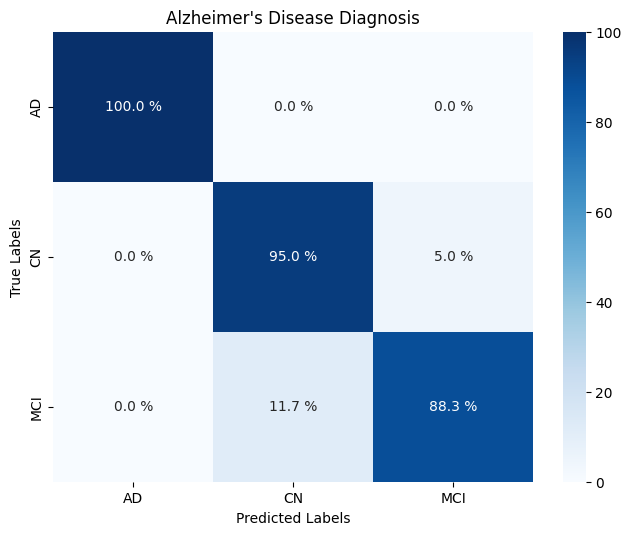

In [ ]:
# Plot the confusion matrix to understand the classification in detail
test_ls, pred_ls = test_images.classes, pred  # Get true and predicted labels
conf_arr = confusion_matrix(test_ls, pred_ls)  # Compute confusion matrix

# Compute percentages
conf_arr_percent = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis] * 100

# plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')  # Set figure size and dpi

# # Plot heatmap with annotations
# ax = sns.heatmap(conf_arr_percent, cmap='Blues', annot=True, fmt='.1f', cbar=True, xticklabels=CLASSES, yticklabels=CLASSES)

# for t in ax.texts:
#     t.set_text(t.get_text() + ' %')

# plt.title('Alzheimer\'s Disease Diagnosis')  # Set title for the plot
# plt.xlabel('Predicted Label')  # Set label for x-axis
# plt.ylabel('True Label')  # Set label for y-axis
# plt.savefig('confusion_matrix_vgg16.png')
# plt.show(ax)  # Display the plot

plt.figure(figsize=(8, 6), dpi=100)  # Set figure size and dpi
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)  # Adjust padding

# Plot heatmap with annotations
ax = sns.heatmap(conf_arr_percent, cmap='Blues', annot=True, fmt='.1f', cbar=True, xticklabels=CLASSES, yticklabels=CLASSES)

for t in ax.texts:
    t.set_text(t.get_text() + ' %')

plt.title('Alzheimer\'s Disease Diagnosis')  # Set title for the plot
plt.xlabel('Predicted Labels')  # Set label for x-axis
plt.ylabel('True Labels')  # Set label for y-axis
plt.savefig('confusion_matrix_loaded_model.png', bbox_inches='tight')  # Save the plot with tight bounding box
plt.show()  # Display the plot

#Analyzing Model Performance with ROC Curve and Thresholds

Analysis of model performance using Receiver Operating Characteristic (ROC) curves by incorporating different classification thresholds.

After converting true labels into a binary format, ROC curves and areas under the curve (AUC) are computed for each class. Additionally, the true positive rate (TPR) and false positive rate (FPR) are calculated for various classification thresholds.

The micro-average ROC curve and AUC are derived by aggregating TPR and FPR across all classes, while the macro-average ROC curve and AUC represent the average performance across all classes.

In the plot:
- Each class's ROC curve is shown as a line, with the area under each curve indicating the performance for that class.
- Points on the curves correspond to different thresholds, allowing visualization of TPR and FPR at specific decision thresholds.

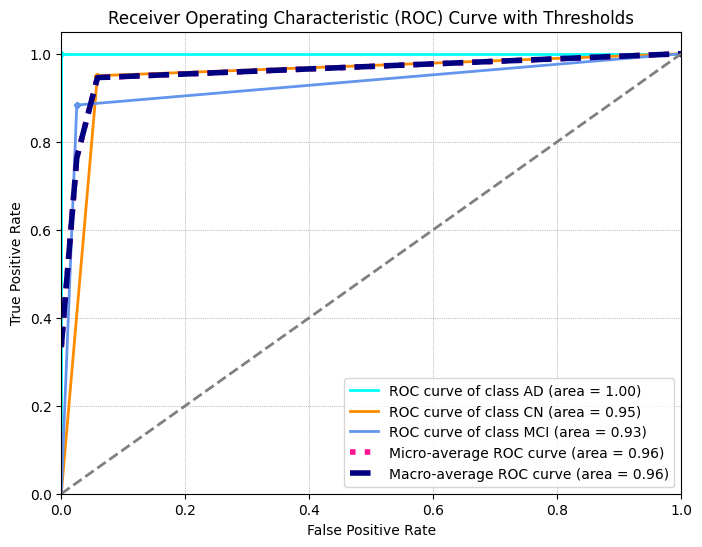

In [ ]:
from sklearn.metrics import matthews_corrcoef as MCC, roc_curve, auc, balanced_accuracy_score as BAS, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# Convert labels to binary format
# Convert true labels to binary format where each class is represented by a binary vector
y_true = label_binarize(test_images.classes, classes=range(len(CLASSES)))  # CLASSES is the list of class names
n_classes = y_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # Area under ROC curve

# Thresholds for which to compute ROC
thresholds = np.linspace(0, 1, 100)  # 100 thresholds between 0 and 1
tpr_values = np.zeros((n_classes, len(thresholds)))
fpr_values = np.zeros((n_classes, len(thresholds)))

# Iterate over each class to compute ROC curve and area
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], pred_labels[:, i])  # Compute FPR, TPR, thresholds
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute area under ROC curve

    # Compute TPR and FPR for different thresholds
    for j, threshold in enumerate(thresholds):
        tp = np.sum((pred_labels[:, i] >= threshold) & (y_true[:, i] == 1))
        fp = np.sum((pred_labels[:, i] >= threshold) & (y_true[:, i] == 0))
        tn = np.sum((pred_labels[:, i] < threshold) & (y_true[:, i] == 0))
        fn = np.sum((pred_labels[:, i] < threshold) & (y_true[:, i] == 1))

        tpr_values[i, j] = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_values[i, j] = fp / (fp + tn) if (fp + tn) > 0 else 0

# Compute micro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))  # Obtain all unique FPR values
mean_tpr = np.zeros_like(all_fpr)  # Initialize mean TPR
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # Interpolate TPR values
mean_tpr /= n_classes  # Calculate mean TPR
fpr["micro"] = all_fpr
tpr["micro"] = mean_tpr
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  # Compute area under micro-average ROC curve

# Compute macro-average ROC curve and ROC area
lw = 2  # Adjust line width if needed
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']  # Adjust colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(CLASSES[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

# Plot macro-average ROC curve
roc_auc_macro = auc(fpr["micro"], tpr["micro"])  # Compute area under macro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='navy', linestyle='--', linewidth=4, label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_macro))

# Plot points for different thresholds
for i, color in zip(range(n_classes), colors):
    for j, threshold in enumerate(thresholds[::10]):
        plt.scatter(fpr_values[i, j*10], tpr_values[i, j*10], color=color, s=10)

# Add random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc="lower right")
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add a delicate grid in the background
# Save the figure as a .png file
plt.savefig('roc_curve_loaded_model.png')
plt.show()

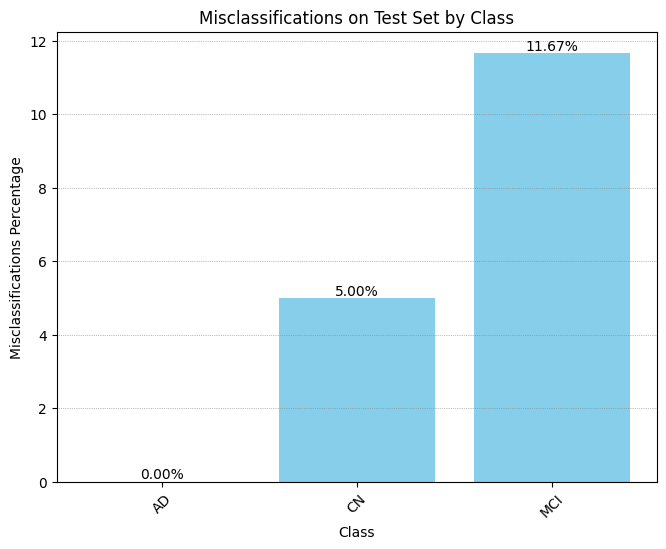

In [ ]:
# Initialize misclassifications for each class
misclassifications = np.zeros(len(CLASSES), dtype=int)

# Initialize total instances for each class
total_instances = np.zeros(len(CLASSES), dtype=int)

# Iterate over each instance in the test set
for true_label, pred_label in zip(test_ls, pred_ls):
    # Increment total instances count for the true label's class
    total_instances[true_label] += 1
    # If the true label and predicted label don't match, increment misclassification count for the true label's class
    if true_label != pred_label:
        misclassifications[true_label] += 1

# Calculate misclassifications as percentages
misclassifications_percentage = (misclassifications / total_instances) * 100

# # Plot the bar chart
# plt.figure(figsize=(8, 6))
# bars = plt.bar(CLASSES, misclassifications_percentage, color='skyblue')
# plt.title('Misclassifications on Test Set by Class (Percentage)')
# plt.xlabel('Class')
# plt.ylabel('Misclassifications Percentage')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle=':', linewidth=0.5, color='gray')

# # Annotate each bar with its percentage value
# for bar, percentage in zip(bars, misclassifications_percentage):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')
# plt.savefig('missclass_vgg16.png')
# plt.show()


plt.figure(figsize=(8, 6))  # Set figure size
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)  # Adjust padding

# Plot the bar chart
bars = plt.bar(CLASSES, misclassifications_percentage, color='skyblue')
plt.title('Misclassifications on Test Set by Class')
plt.xlabel('Class')
plt.ylabel('Misclassifications Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle=':', linewidth=0.5, color='gray')

# Annotate each bar with its percentage value
for bar, percentage in zip(bars, misclassifications_percentage):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')

plt.savefig('missclass_loaded_model.png', bbox_inches='tight')  # Save the plot with tight bounding box
plt.show()  # Display the plot

6/6 [==============================] - 2s 89ms/step - loss: 0.1402 - acc: 0.9444 - auc: 0.9938 - f1_score: 0.9444
Testing Accuracy: 94.44%
6/6 [==============================] - 1s 75ms/step


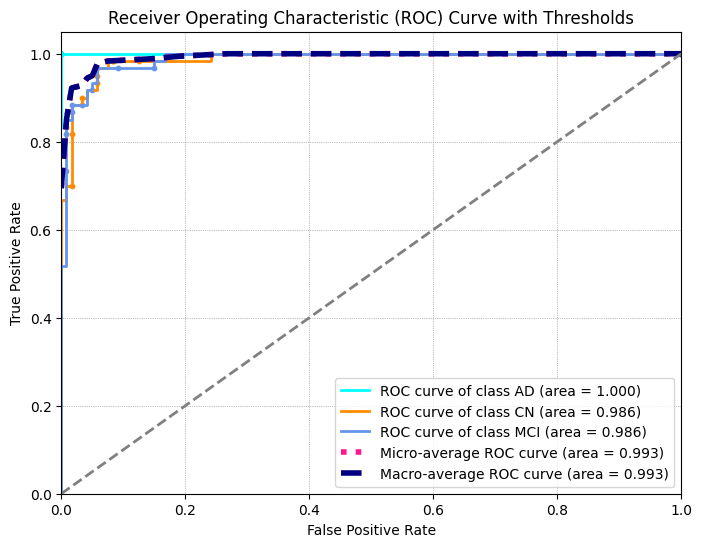

              precision    recall  f1-score   support

          AD       1.00      1.00      1.00        60
          CN       0.89      0.95      0.92        60
         MCI       0.95      0.88      0.91        60

    accuracy                           0.94       180
   macro avg       0.95      0.94      0.94       180
weighted avg       0.95      0.94      0.94       180



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

# Provide the path to the saved model file (.h5 format)
model_path = '/content/model_best_weights.keras'
# Load the model
loaded_model = load_model(model_path)

# Evaluate the model on test data
test_scores = loaded_model.evaluate(test_images)
print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))

# Predict probabilities for test images
pred_labels = loaded_model.predict(test_images)

# Convert labels to binary format where each class is represented by a binary vector
y_true = label_binarize(test_images.classes, classes=range(len(CLASSES)))  # CLASSES is the list of class names
n_classes = y_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # Area under ROC curve

# Thresholds for which to compute ROC
thresholds = np.linspace(0, 1, 100)  # 100 thresholds between 0 and 1
tpr_values = np.zeros((n_classes, len(thresholds)))
fpr_values = np.zeros((n_classes, len(thresholds)))

# Iterate over each class to compute ROC curve and area
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], pred_labels[:, i])  # Compute FPR, TPR, thresholds
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute area under ROC curve

    # Compute TPR and FPR for different thresholds
    for j, threshold in enumerate(thresholds):
        tp = np.sum((pred_labels[:, i] >= threshold) & (y_true[:, i] == 1))
        fp = np.sum((pred_labels[:, i] >= threshold) & (y_true[:, i] == 0))
        tn = np.sum((pred_labels[:, i] < threshold) & (y_true[:, i] == 0))
        fn = np.sum((pred_labels[:, i] < threshold) & (y_true[:, i] == 1))

        tpr_values[i, j] = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_values[i, j] = fp / (fp + tn) if (fp + tn) > 0 else 0

# Compute micro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))  # Obtain all unique FPR values
mean_tpr = np.zeros_like(all_fpr)  # Initialize mean TPR
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # Interpolate TPR values
mean_tpr /= n_classes  # Calculate mean TPR
fpr["micro"] = all_fpr
tpr["micro"] = mean_tpr
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  # Compute area under micro-average ROC curve

# Compute macro-average ROC curve and ROC area
roc_auc_macro = auc(fpr["micro"], tpr["micro"])  # Compute area under macro-average ROC curve

# Plot ROC curve for each class
lw = 2  # Adjust line width if needed
plt.figure(figsize=(8, 6))

colors = ['aqua', 'darkorange', 'cornflowerblue']  # Adjust colors if needed
for i, color in zip(range(n_classes), colors):
    plt.step(fpr_values[i], tpr_values[i], color=color, lw=lw, where='post',
             label='ROC curve of class {0} (area = {1:0.3f})'.format(CLASSES[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.3f})'.format(roc_auc["micro"]))

# Plot macro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='navy', linestyle='--', linewidth=4,
         label='Macro-average ROC curve (area = {0:0.3f})'.format(roc_auc_macro))

# Plot points for different thresholds
for i, color in zip(range(n_classes), colors):
    for j, threshold in enumerate(thresholds[::10]):
        plt.scatter(fpr_values[i, j*10], tpr_values[i, j*10], color=color, s=10)

# Add random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Thresholds')
plt.legend(loc="lower right")
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add a delicate grid in the background
# Save the figure as a .png file
plt.savefig('roc_curve_loaded_model_new.png')
plt.show()

# Print classification report
pred = np.argmax(pred_labels, axis=1)  # Get the index of the maximum value along the axis 1
print(classification_report(test_images.classes, pred, target_names=CLASSES))

# # Save the evaluation and classification report to a file
import sys

# # Save the original standard output
original_stdout = sys.stdout

# # Open a file in write mode to save the information
with open('loaded_model_evaluation_info.txt', 'w') as f:
  # Redirect the standard output to the file
  sys.stdout = f
  # Evaluate the model on test data
  test_scores = loaded_model.evaluate(test_images)
  print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))  # Print the testing accuracy

  # Print classification report to the file
  print(classification_report(test_images.classes, pred, target_names=CLASSES))

  # Reset the standard output to the original value
  sys.stdout = original_stdout

#Printing Additional Classification Metrics

1. **Balanced Accuracy Score (BAS)** - a metric that provides a balanced measure of classification performance, particularly useful for imbalanced datasets. It considers both the sensitivity (true positive rate) and specificity (true negative rate) of the model's predictions.

2. **Matthew's Correlation Coefficient (MCC)** - a metric that measures the quality of binary classifications, taking into account both true and false positives and negatives. It ranges from -1 to 1, where 1 indicates perfect predictions, 0 indicates random predictions, and -1 indicates complete disagreement between predictions and true labels.

In [ ]:
# Open a text file in write mode
with open('classification_metrics_loaded_model.txt', 'w') as f:
    # Write Balanced Accuracy Score (BAS) to the file
    f.write("Balanced Accuracy Score: {} %\n".format(round(BAS(test_ls, pred_ls) * 100, 2)))

    # Write Matthew's Correlation Coefficient (MCC) to the file
    f.write("Matthew's Correlation Coefficient: {} %\n".format(round(MCC(test_ls, pred_ls) * 100, 2)))

# Print a message indicating that the metrics have been saved
print("Classification metrics have been saved to 'classification_metrics_loaded_model.txt'.")

# Printing some other classification metrics

# Balanced Accuracy Score (BAS): Measure of classification performance that accounts for imbalanced datasets.
# Compute BAS and format the output as a percentage rounded to two decimal places.
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))

# Matthew's Correlation Coefficient (MCC): Measure of the quality of binary classifications, accounting for both true and false positives and negatives.
# Compute MCC and format the output as a percentage rounded to two decimal places.
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Classification metrics have been saved to 'classification_metrics_loaded_model.txt'.
Balanced Accuracy Score: 94.44 %
Matthew's Correlation Coefficient: 91.73 %


#Saving Custom CNN Model

Saving a custom Convolutional Neural Network (CNN) model along with its performance score in the filename. The model is saved in the Keras HDF5 format.

The filename includes the identifier "custom_cnn_v1_" followed by the performance score enclosed in parentheses. The inclusion of the performance score in the filename allows for easy identification and tracking of models based on their performance without needing to open them.

In [ ]:
# Save the custom CNN model with the given filename including its performance score
loaded_model.save('/content/drive/MyDrive/ADNI Custom/2D Analysis/TL/ResNet50_half_frozen/model_best_weights_frozen.keras')